# Imports

In [1]:
import pandas as pd
import numpy as np
np.random.seed(2121)

import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
batpos = pd.read_csv('../data/batpos_eda.csv')

# Lookbacks

The nature of our dataset is that a player's performance will be across multiple lines in our dataset. We are interested in players who have a consecutive set of years in the database so we can look into their historical performance to make inferences.

A few approaches will be made to see how our dataset changes (in number of rows) for lookback windows of 2, 3, 5, and 10 years.

## Calculate lookback loss

In [3]:
# sort df by player-year to ensure proper shifting
batpos = batpos.sort_values(['player_id','year_id'])

In [4]:
def lookback_counts(yr):
    '''returns the count of rows remaining in the df using a lookback
       value of yr where the yrs must be non-null and consecutive'''
    
    # create our working df
    _yrlookback =\
        pd.Series(
            pd.DataFrame(
                    [batpos.groupby('player_id')['year_id'].shift(i)
                     for i in range(1,yr+1)]).T.values.tolist(),
        name='_yr_lookback')
    
    df = batpos.join(_yrlookback)
    
     
    # remove rows where _yr_lookback array includes a nan
    # create mask to count nulls
    null_count = df['_yr_lookback']\
                    .map(lambda x: sum([1 if pd.isnull(i) else 0 for i in x]))

    # use mask to keep only rows with mask value 0
    df = df.loc[null_count==0]
    
     # remove rows where _yr_lookback years aren't consecutive
    consec = df.apply(lambda row:
                 [row.year_id - x for x in row['_yr_lookback']] 
                      == list(range(1,yr+1))
                    , axis = 1)

    # use mask to keep only rows with mask value 0
    df = df.loc[consec]
    
    return df.shape[0], df

## Lookback comparisions

The longer our lookback, the fewer players we can expect to have in our dataset. To qualify for a specific lookback window, the player must have that number of consecutive years +1 in the dataset.

In [5]:
lb2 = lookback_counts(2) # 2year
lb3 = lookback_counts(3) # 3
lb5 = lookback_counts(5) # 5
lb10 = lookback_counts(10) #10 
rows = batpos.shape[0] #players we started with

print('Lookback Loss\n')

print(f'2 year lookback: {lb2[0]} rows\n'+\
      f'{lb2[0]/rows:.2f} of original\n'+\
      f'{lb2[1].name_common.unique().shape[0]} players total\n')

print(f'3 year lookback: {lb3[0]} rows\n'+\
      f'{lb3[0]/rows:.2f} of original\n'+\
      f'{lb3[1].name_common.unique().shape[0]} players total\n')

print(f'5 year lookback: {lb5[0]} rows\n'+\
      f'{lb5[0]/rows:.2f} of original\n'+\
      f'{lb5[1].name_common.unique().shape[0]} players total\n')

print(f'10 year lookback: {lb10[0]} rows\n'+\
      f'{lb10[0]/rows:.2f} of original\n'+\
      f'{lb10[1].name_common.unique().shape[0]} players total\n')


Lookback Loss

2 year lookback: 3596 rows
0.47 of original
832 players total

3 year lookback: 2615 rows
0.34 of original
639 players total

5 year lookback: 1392 rows
0.18 of original
376 players total

10 year lookback: 239 rows
0.03 of original
78 players total



The 3 year lookback seems to be a happy medium where we will have a decent amount of lookback and not lose more than two thirds of our dataset. Let's use 3 for our lookback meaning our target will be that fourth year's `waa_pg`

## Lookback Feature Extraction

### Standard Lookback approach (3-year)

In [6]:
# create lookbacks for everything except our player vars, year, and age
cols = [c for c in batpos.columns
        if c not in ['player_id', 'year_id', 'name_common', 'age']]

for c in cols:
    for i in range(1,4):
        batpos[c+'_'+str(i)+'yr'] =\
        pd.DataFrame(
                [batpos.groupby('player_id')[c].shift(i)]).T

In [7]:
# using the df from our 3-year lookback, merge with batpos to mask it
batpos = pd.merge(lb3[1][['player_id','year_id']], batpos,
                  on = ['player_id', 'year_id'])

# reorder
batpos = batpos[['waa_pg']].join(batpos.loc[:, batpos.columns!='waa_pg'])

# Approach

We now have a dataframe with a player's season stats as well as the past three season stats.

Two approaches will be used to preprocess the data for modeling.
  1.  Drop the non-lookback variables of our dataset and try to model `waa_pg` all at once
  2.  Split the dataset into three different datasets to model in stages.
  
The second approach will be discussed in the RDF_YDF notebooks. For now, let's package and save our current batpos dataframe so it can be used for that.

In [8]:
batpos.to_csv('../data/batpos_feature_extracted.csv', index=False)

# EDA

The approach here requires us to only be looking at look-backs to determine season performance. Drop season performance features.

In [9]:
# remove 
batpos.drop(['g', 'team_gp',
             'pa_pg', 'inn_pg', 'runs_bat_pg', 'runs_br_pg', 'runs_dp_pg',
             'runs_defense_pg', 'runs_position_pg', 'opprpg',
             'percent_team_gp','pa_per_team_gp', 'inn_per_team_gp',
             'g_c_share', 'g_1b_share','g_2b_share', 'g_3b_share',
             'g_ss_share', 'g_cf_share', 'g_of','g_dh_share', 'g_cof_share'],
           axis = 1, inplace=True)

In [10]:
def triple_regplot(features, target, data):
    fig, ax = plt.subplots(1,3,figsize=(21,7))
    
    sns.regplot(x=features[0], y=target, data=data,
                scatter_kws={'alpha':0.2},
                line_kws={'color': 'red'},
                ax=ax[0])\
    .set(title=target+' vs '+features[0]+'\nCorr:'+\
         str(round(data.corr().loc[target,features[0]],2)))
    
    sns.regplot(x=features[1], y=target, data=data,
            color='rebeccapurple',
            scatter_kws={'alpha':0.2},
            line_kws={'color': 'red'},
            ax=ax[1])\
    .set(title=target+' vs '+features[1]+'\nCorr:'+\
         str(round(data.corr().loc[target,features[1]],2)))

    sns.regplot(x=features[2], y=target, data=data,
                color='darkseagreen',
                scatter_kws={'alpha':0.2},
                line_kws={'color': 'red'},
                ax=ax[2])\
    .set(title=target+' vs '+features[2]+'\nCorr:'+\
         str(round(data.corr().loc[target,features[2]],2)))

## `waa_pg` vars

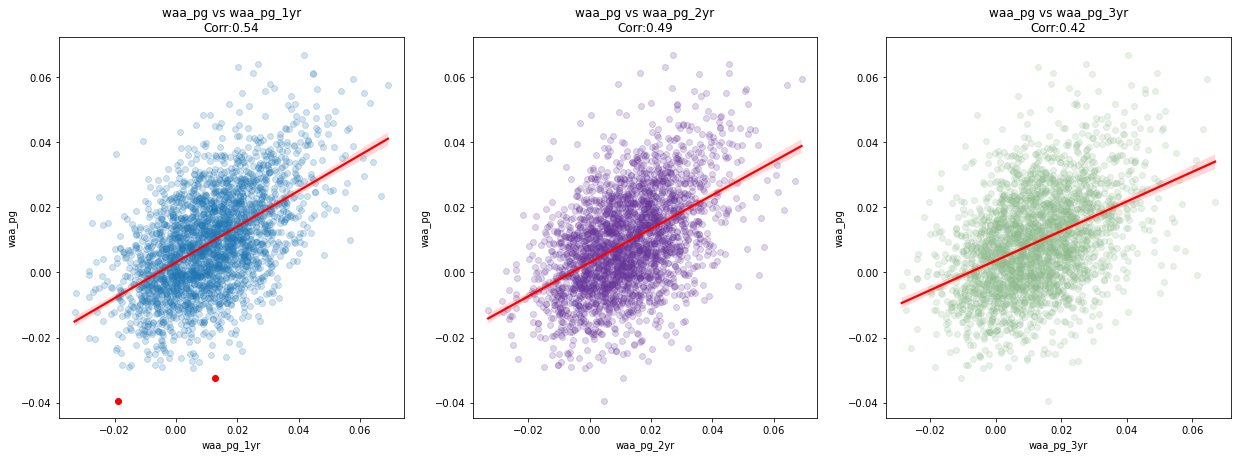

In [11]:
triple_regplot(['waa_pg_1yr','waa_pg_2yr','waa_pg_3yr'],
               'waa_pg', batpos)
ax = plt.gcf().get_axes()
y_lim = ax[0].get_ylim()

mask = batpos.waa_pg < -.03
ax[0].scatter(batpos[mask].waa_pg_1yr, batpos[mask].waa_pg, color='red');

## `g` vars

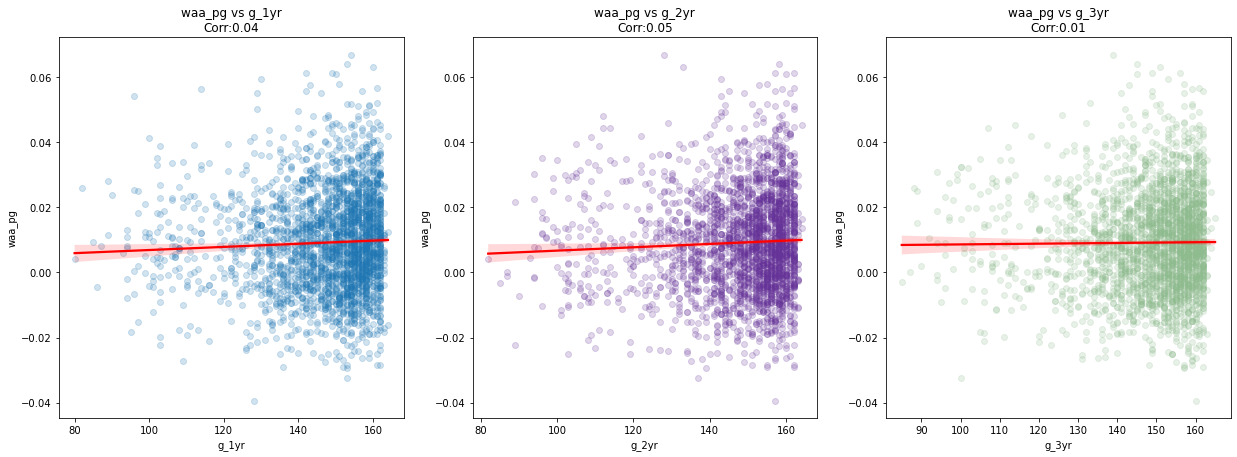

In [12]:
triple_regplot(['g_1yr','g_2yr','g_3yr'],
               'waa_pg', batpos);

Expect this to be dropped

## `team_gp` vars

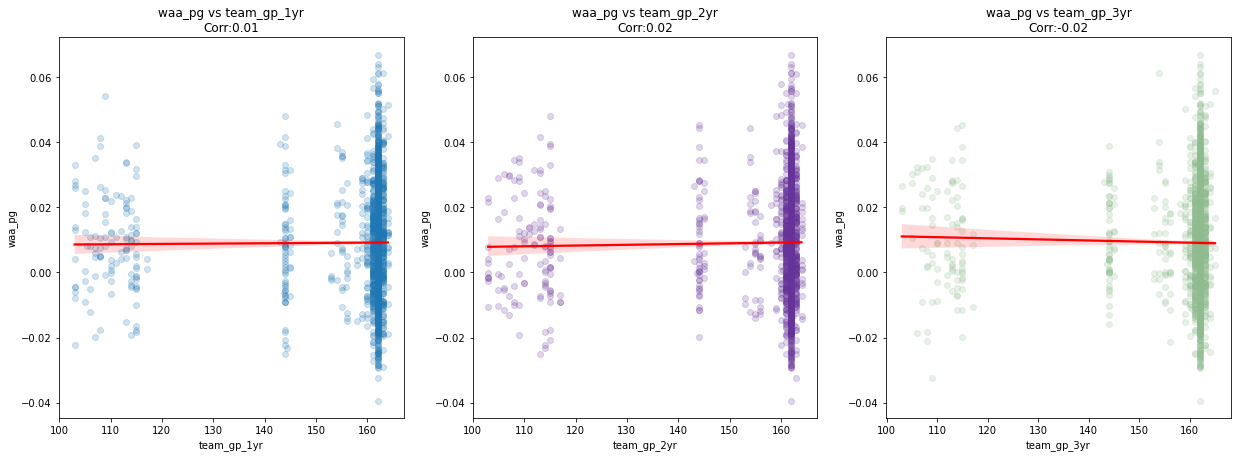

In [13]:
triple_regplot(['team_gp_1yr','team_gp_2yr', 'team_gp_3yr'],
               'waa_pg', batpos);

Expect this to be dropped

## `pa_pg` vars

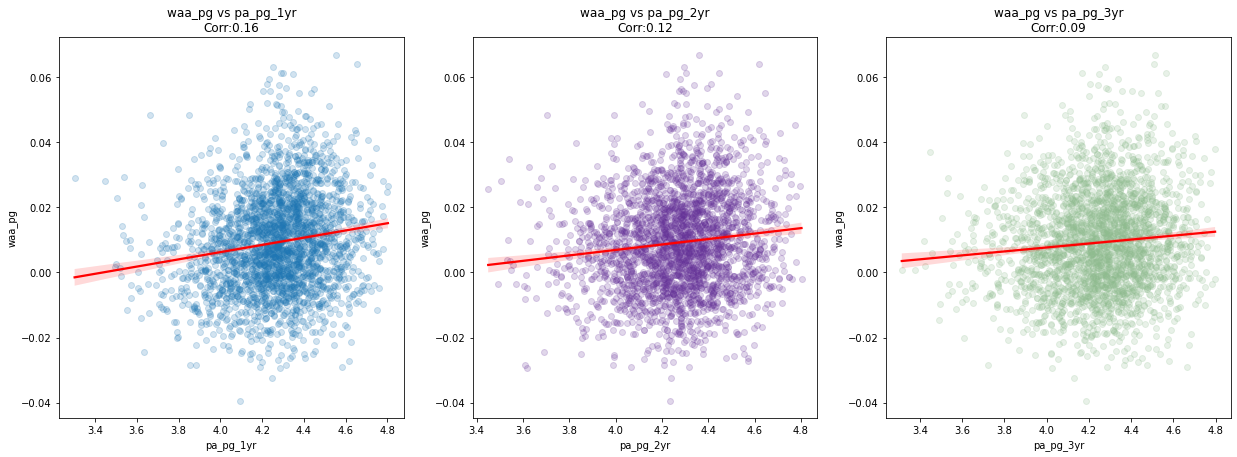

In [14]:
triple_regplot(['pa_pg_1yr', 'pa_pg_2yr', 'pa_pg_3yr'],
               'waa_pg', batpos);

This is a pretty weak correlation. Avoid dropping outliers here.

## `inn_pg` vars

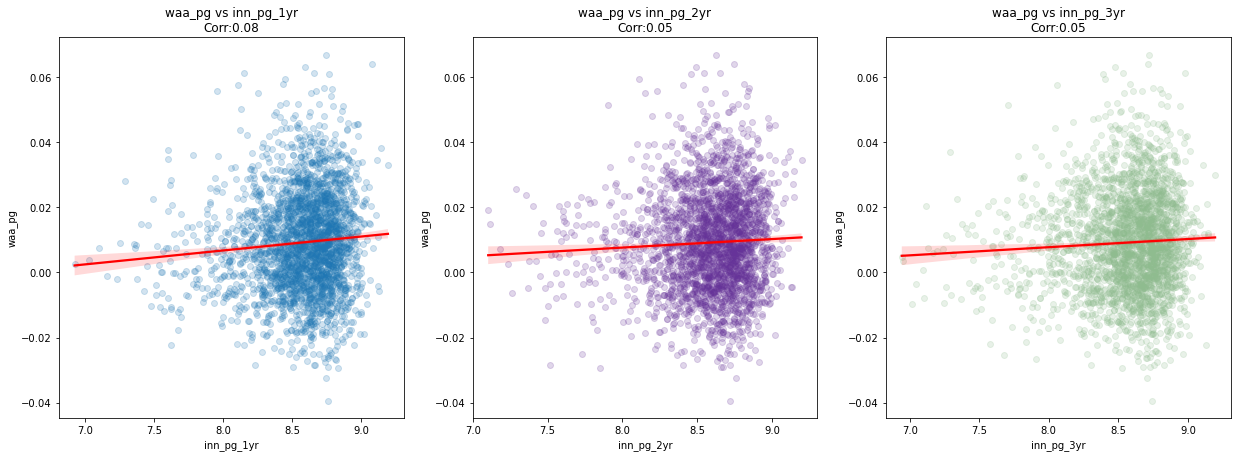

In [15]:
triple_regplot(['inn_pg_1yr', 'inn_pg_2yr', 'inn_pg_3yr'],
               'waa_pg', batpos);


This is a pretty weak correlation. Avoid dropping outliers here.

## `runs_bat_pg` vars

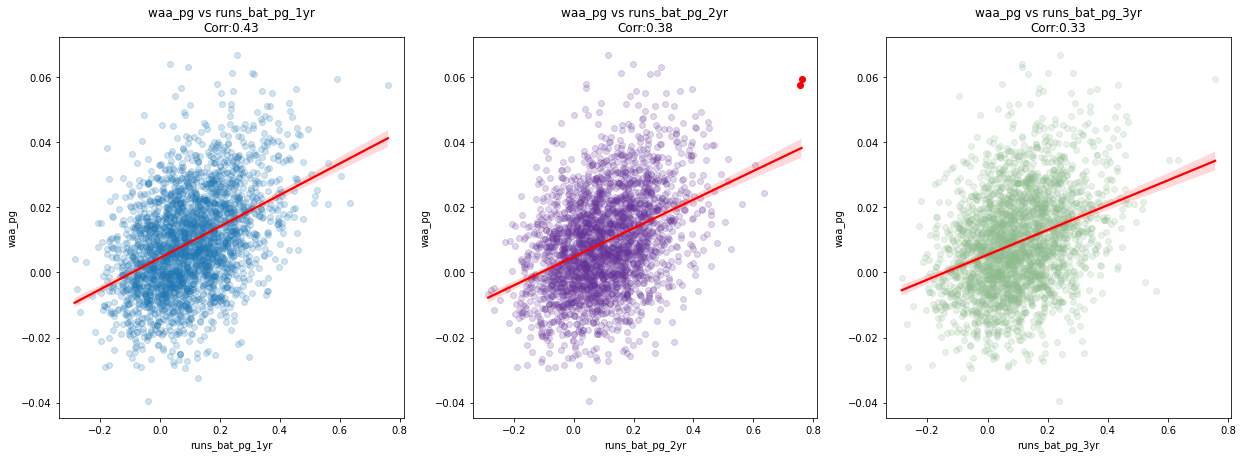

In [16]:
triple_regplot(['runs_bat_pg_1yr','runs_bat_pg_2yr', 'runs_bat_pg_3yr'],
               'waa_pg', batpos)
ax = plt.gcf().get_axes()
x_lim = ax[0].get_xlim()

mask = batpos.runs_bat_pg_2yr>0.65
mask2 = batpos.runs_bat_pg_3yr
ax[1].scatter(batpos[mask].runs_bat_pg_2yr, batpos[mask].waa_pg, color='red');

In [17]:
batpos = batpos[(~mask)]

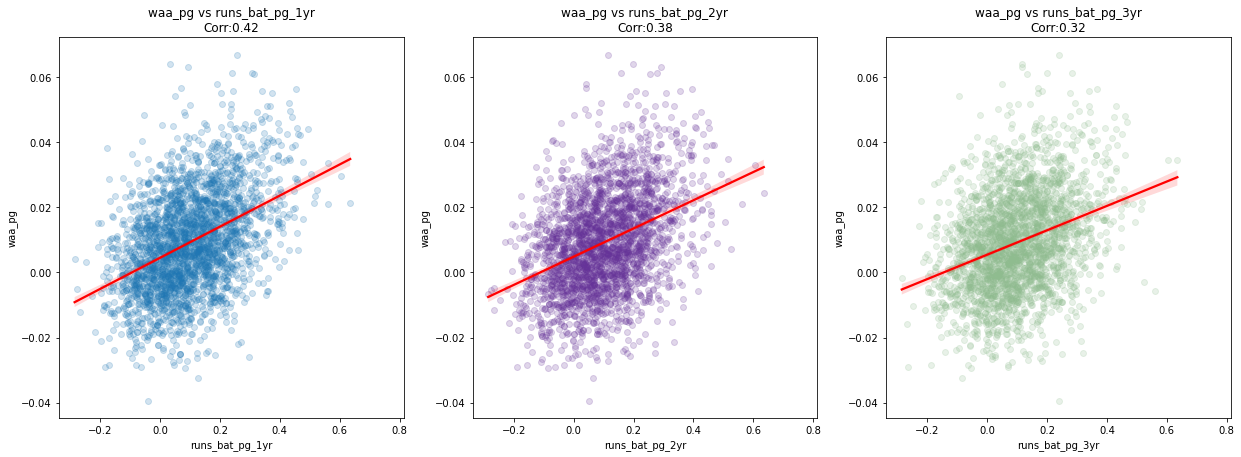

In [18]:
triple_regplot(['runs_bat_pg_1yr','runs_bat_pg_2yr', 'runs_bat_pg_3yr'],
               'waa_pg', batpos)
ax = plt.gcf().get_axes()
for i in range(3):
    ax[i].set_xlim(xmin=x_lim[0],xmax=x_lim[1])

## `runs_bat_pg` vars

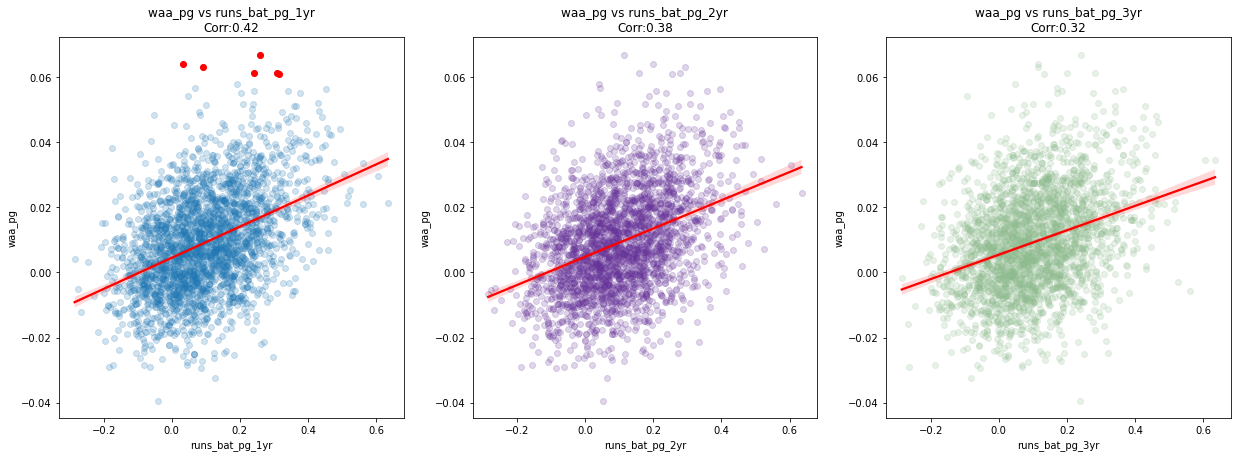

In [19]:
triple_regplot(['runs_bat_pg_1yr','runs_bat_pg_2yr', 'runs_bat_pg_3yr'],
               'waa_pg', batpos)
ax = plt.gcf().get_axes()
y_lim = ax[0].get_ylim()

mask = batpos.waa_pg>0.06
ax[0].scatter(batpos[mask].runs_bat_pg_1yr, batpos[mask].waa_pg, color='red');

In [20]:
batpos = batpos[(~mask)]

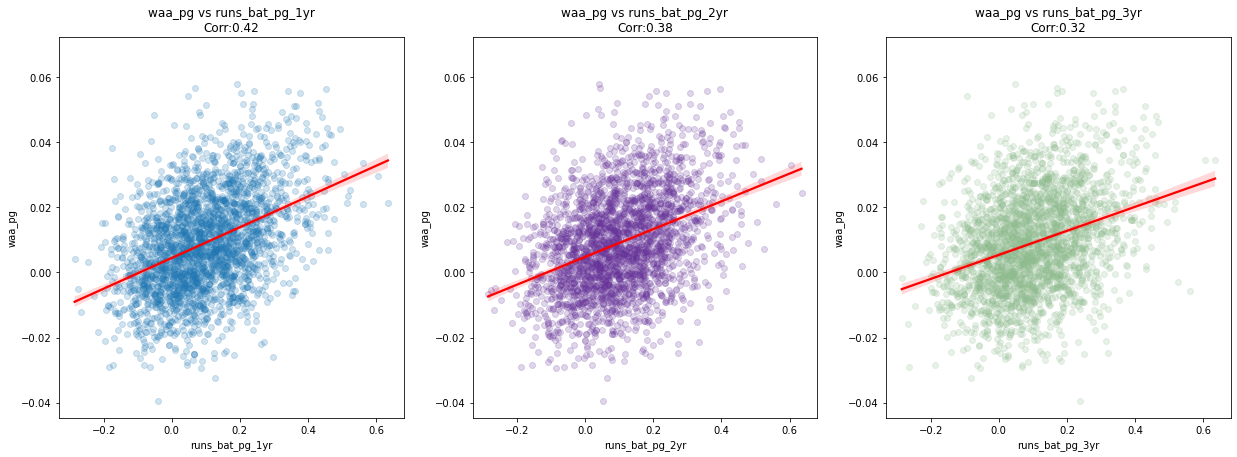

In [21]:
triple_regplot(['runs_bat_pg_1yr','runs_bat_pg_2yr', 'runs_bat_pg_3yr'],
               'waa_pg', batpos)
ax = plt.gcf().get_axes()
for i in range(3):
    ax[i].set_ylim(ymin=y_lim[0],ymax=y_lim[1])

## `runs_br_pg` vars

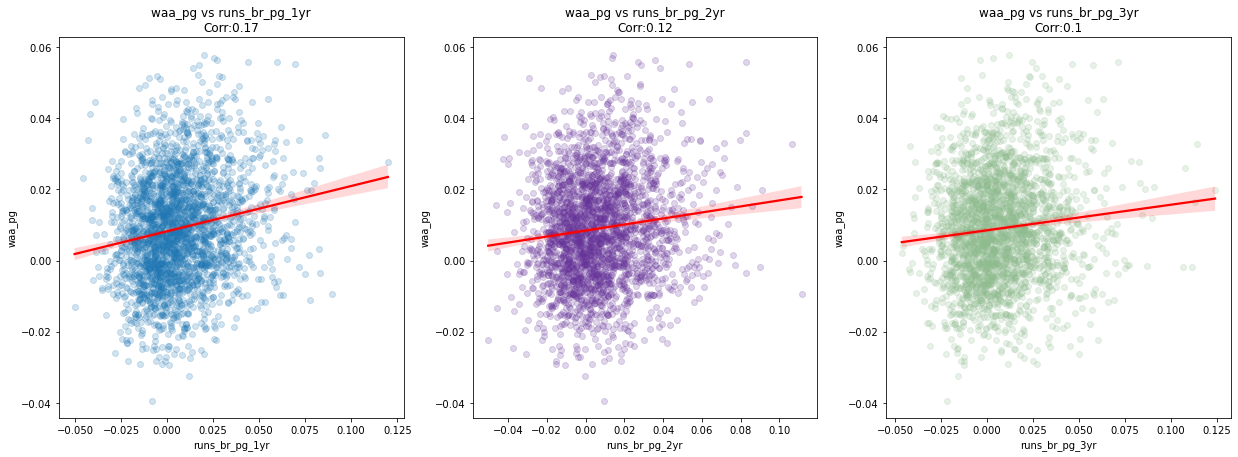

In [22]:
triple_regplot(['runs_br_pg_1yr','runs_br_pg_2yr', 'runs_br_pg_3yr'],
               'waa_pg', batpos)

This is a pretty weak correlation. Avoid dropping outliers here.

## `runs_dp_pg` vars

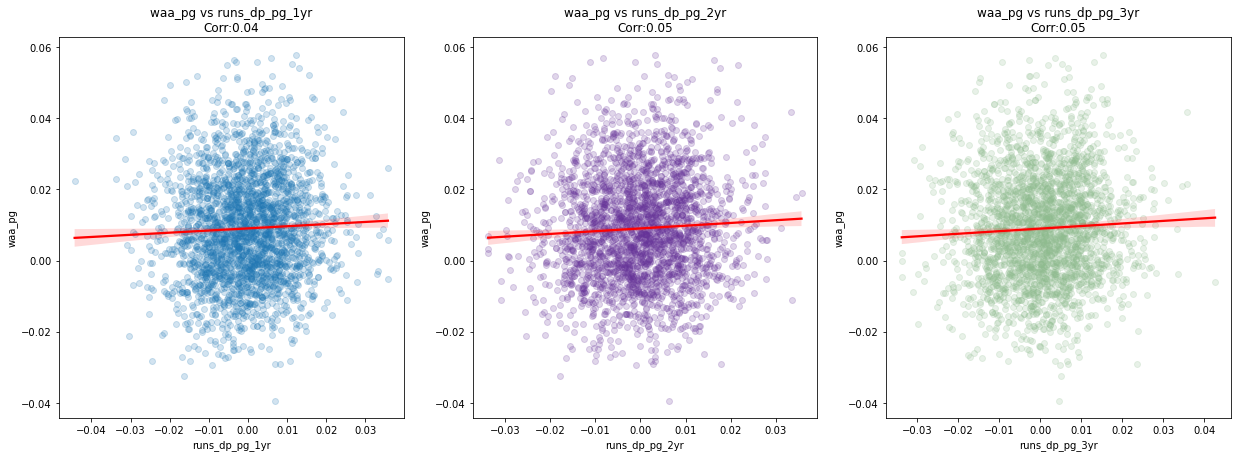

In [23]:
triple_regplot(['runs_dp_pg_1yr', 'runs_dp_pg_2yr','runs_dp_pg_3yr'],
               'waa_pg', batpos)

## `runs_defense_pg` vars

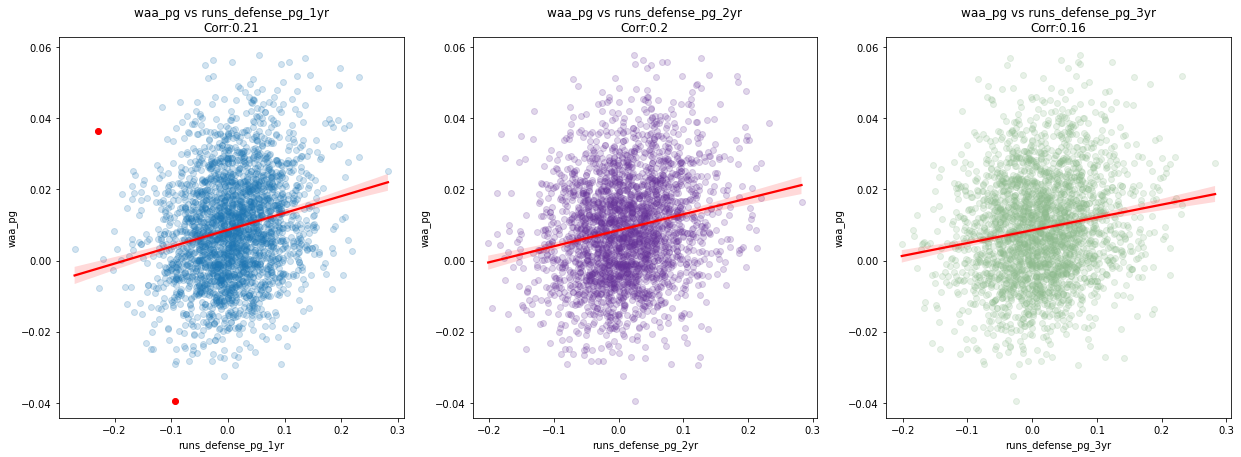

In [24]:
triple_regplot(['runs_defense_pg_1yr', 'runs_defense_pg_2yr',
                'runs_defense_pg_3yr'],
               'waa_pg', batpos)
ax = plt.gcf().get_axes()

mask=(batpos.runs_defense_pg_1yr<-0.2) & (batpos.waa_pg>0.03)
mask2=batpos.waa_pg<-.035
ax[0].scatter(batpos[mask|mask2].runs_defense_pg_1yr, batpos[mask|mask2].waa_pg,
              color='red')

In [25]:
batpos = batpos[(~mask)&(~mask2)]

## `runs_position_pg` vars

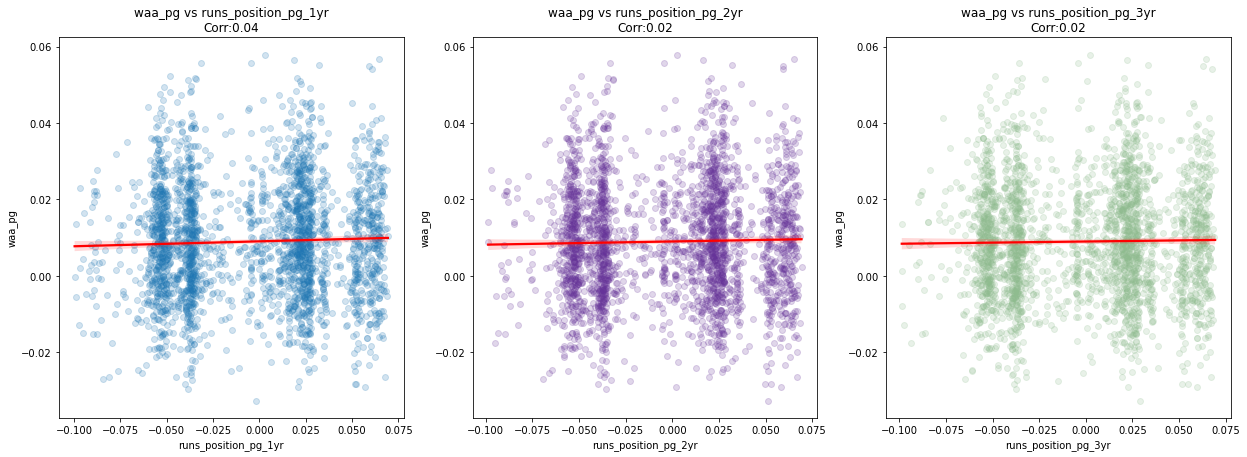

In [26]:
triple_regplot(['runs_position_pg_1yr', 'runs_position_pg_2yr',
                'runs_position_pg_3yr'],
                'waa_pg', batpos)

Expect this to get dropped

## `opprpg` vars

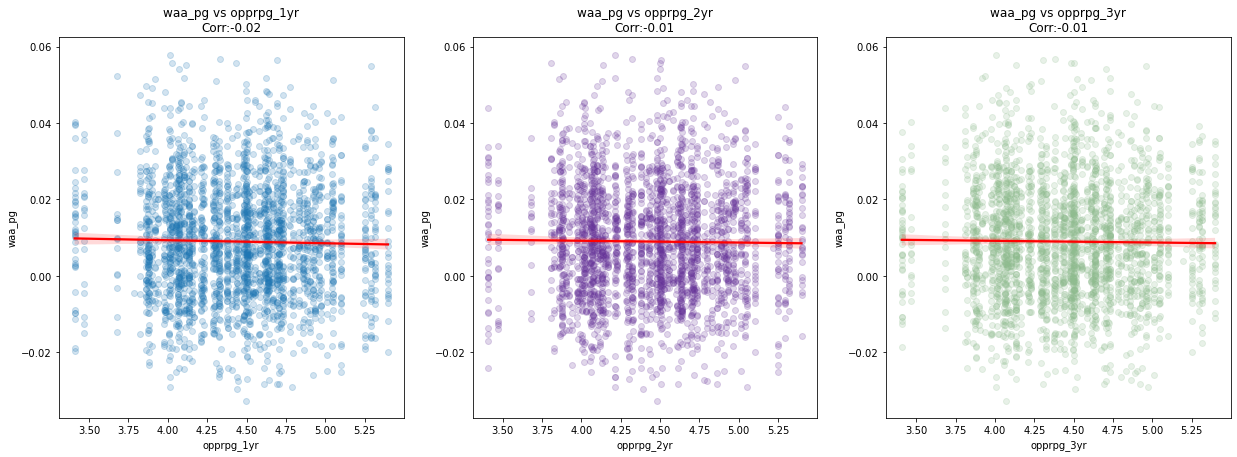

In [27]:
 triple_regplot(['opprpg_1yr', 'opprpg_2yr', 'opprpg_3yr'],
                'waa_pg', batpos)

Expect this to get dropped

## `percent_team_gp` vars

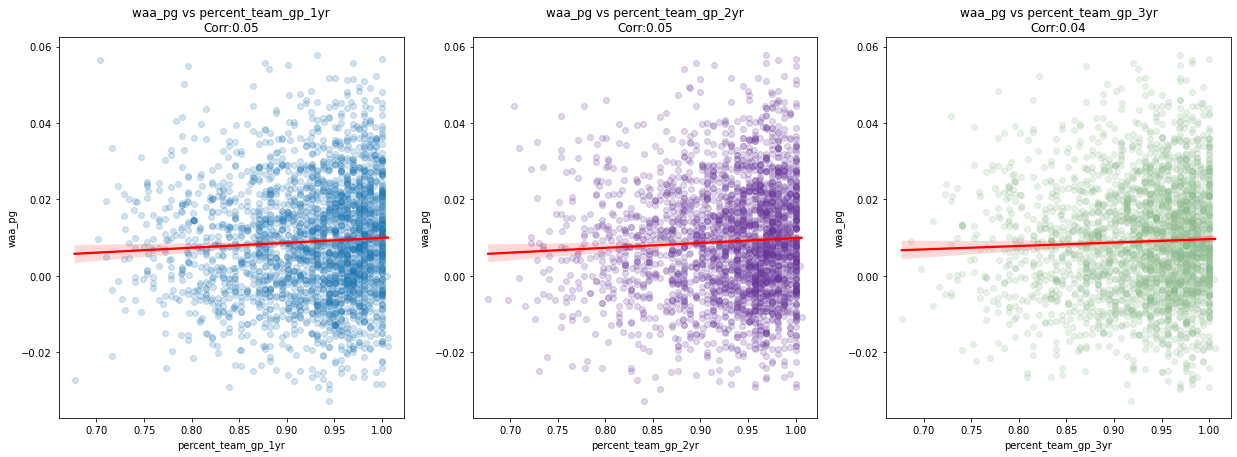

In [28]:
 triple_regplot(['percent_team_gp_1yr', 'percent_team_gp_2yr',
                 'percent_team_gp_3yr'],
                'waa_pg', batpos)
       

Expect this to get dropped.

## `pa_per_team_gp` vars

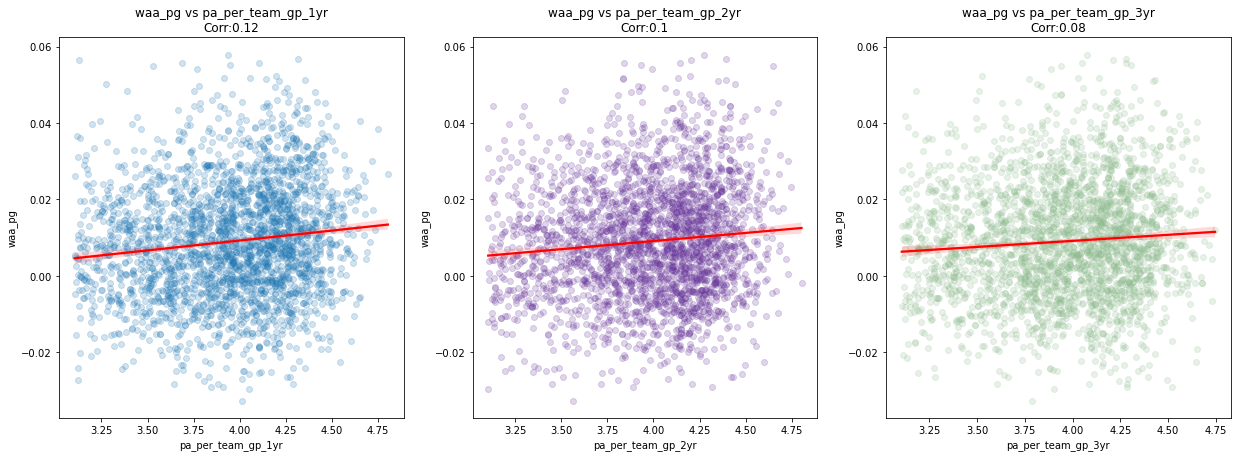

In [29]:
triple_regplot(['pa_per_team_gp_1yr', 'pa_per_team_gp_2yr',
                'pa_per_team_gp_3yr'],
                'waa_pg', batpos)

This is a pretty weak correlation. Avoid dropping outliers here.

## `inn_per_team_gp` vars

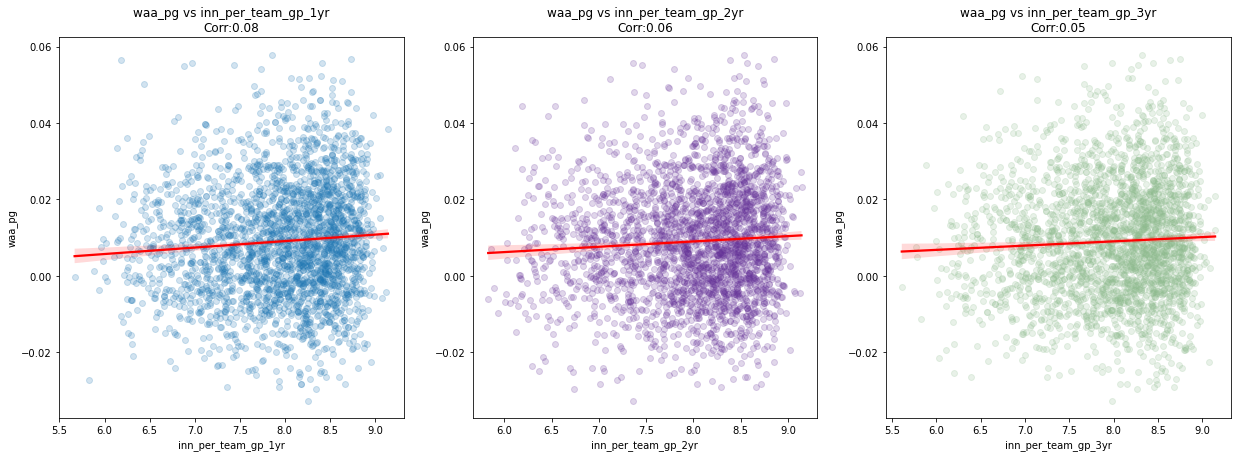

In [30]:
triple_regplot(['inn_per_team_gp_1yr', 'inn_per_team_gp_2yr',
                'inn_per_team_gp_3yr'],
                'waa_pg', batpos)

Expect this to get dropped.

## Position Shares

In lieu of examining each position share look-back, examine the correlation of them. If they are low, assume that they will follow the same distribution as shown in 01_Data_Cleaning.

In [31]:
pos = ['g_c_share_1yr', 'g_c_share_2yr', 'g_c_share_3yr', 'g_1b_share_1yr',
       'g_1b_share_2yr', 'g_1b_share_3yr', 'g_2b_share_1yr', 'g_2b_share_2yr',
       'g_2b_share_3yr', 'g_3b_share_1yr', 'g_3b_share_2yr', 'g_3b_share_3yr',
       'g_ss_share_1yr', 'g_ss_share_2yr', 'g_ss_share_3yr', 'g_cf_share_1yr',
       'g_cf_share_2yr', 'g_cf_share_3yr', 'g_of_1yr', 'g_of_2yr', 'g_of_3yr',
       'g_dh_share_1yr', 'g_dh_share_2yr', 'g_dh_share_3yr', 'g_cof_share_1yr',
       'g_cof_share_2yr', 'g_cof_share_3yr'][::-1]

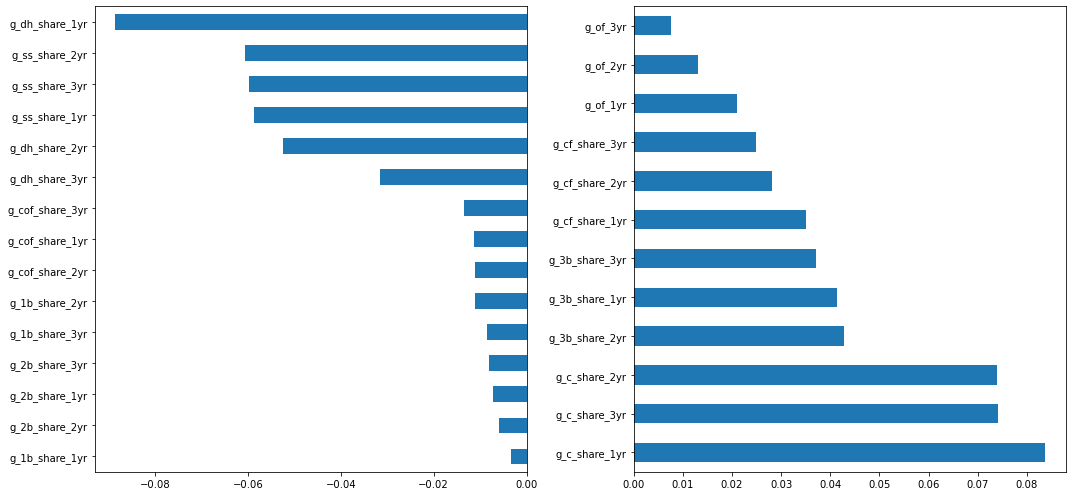

In [32]:
fig, ax = plt.subplots(1,2,figsize=(15,7))

batpos.corr().loc['waa_pg',pos].sort_values()[:15][::-1].plot(kind='barh',ax=ax[0])
batpos.corr().loc['waa_pg',pos].sort_values()[15:][::-1].plot(kind='barh',ax=ax[1])
plt.tight_layout()

**Observation** From this we can see that DH, SS, and C all have the most effect on waa_pg.

**Note** Despite this, the highest absolute correlation coefficient is still below 0.10. Every single one of these I would expect to see dropped during preprocessing.

# Exports

In [33]:
batpos.to_csv('../data/batpos_full_feature_extracted.csv', index=False)